# Green House Time Series RNN

- The goal is to predict the Air Temperature ('Tair') in the next 5, 10, 15.. minutes
- ...based on a sequence of weather features such as the past Air Temperature,  relative humidity, CO2 air etc..

## Libraries

Import the usual libraries:

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os

# Deep Learning
import tensorflow as tf

/home/proctor/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-11-06 14:55:55.708695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-06 14:55:55.708769: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from typing import Dict, List, Tuple, Sequence

## Import Dataset


Import preprocessed dataset

In [3]:
df = pd.read_csv('GreenhouseClimate.csv')
df

/tmp/ipykernel_576/2091057874.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('GreenhouseClimate.csv')


,%time,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,...,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
0,43815.00000,0,35,472,0.4,4.0,100,7.2,0.0,45.2,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000,NaN,1.2
1,43815.00347,0,85,501,0.5,4.0,100,6.9,0.0,43.6,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000,NaN,1.2
2,43815.00694,0,96,489,0.5,4.0,100,7.2,0.0,42.3,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000,NaN,1.2
3,43815.01042,0,96,497,0.5,4.0,100,6.7,0.0,41.2,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000,NaN,1.2
4,43815.01389,0,96,477,0.5,4.0,100,6.7,0.0,41.2,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000,NaN,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47804,43980.98611,0,0,461,1.6,10.4,0,2.7,0.0,0.0,...,0.0,0.0,18.0,18.0,20.0,18.0,NaN,30,0.0,0.0
47805,43980.98958,0,0,466,1.6,10.3,0,2.5,0.0,0.0,...,0.0,0.0,18.0,18.0,20.0,18.0,NaN,30,0.0,0.0
47806,43980.99306,0,0,474,1.6,10.3,5,2.5,0.0,0.0,...,0.0,0.0,18.0,18.0,20.0,18.0,NaN,30,0.0,0.0
47807,43980.99653,0,0,476,1.6,10.3,5,2.4,0.0,0.0,...,0.0,0.0,18.0,18.0,20.0,18.0,NaN,30,0.0,0.0


## Prepare the dataset

In [4]:
df.rename(columns={"%time": "Time"}, inplace=True)
df['Time'] = pd.to_datetime(df['Time'], unit='D', origin='1899-12-30')

In [5]:
df= df[['Rhair', 'Tair', 'CO2air', 'HumDef', 'pH_drain_PC', 'EC_drain_PC', 'Tot_PAR', 'Tot_PAR_Lamps']]
df.columns     

Index(['Rhair', 'Tair', 'CO2air', 'HumDef', 'pH_drain_PC', 'EC_drain_PC',
       'Tot_PAR', 'Tot_PAR_Lamps'],
      dtype='object')

In [34]:
#convert object to float64
df = df.astype(float)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47809 entries, 0 to 47808
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rhair          47738 non-null  float64
 1   Tair           47738 non-null  float64
 2   CO2air         47738 non-null  float64
 3   HumDef         47738 non-null  float64
 4   pH_drain_PC    47738 non-null  float64
 5   EC_drain_PC    47738 non-null  float64
 6   Tot_PAR        47738 non-null  float64
 7   Tot_PAR_Lamps  47809 non-null  float64
dtypes: float64(8)
memory usage: 2.9 MB


In [36]:
df

,Rhair,Tair,CO2air,HumDef,pH_drain_PC,EC_drain_PC,Tot_PAR,Tot_PAR_Lamps
0,60.6,20.9,472.0,7.2,6.3,4.0,0.0,0.0
1,61.4,20.7,501.0,6.9,6.3,4.0,0.0,0.0
2,60.9,21.2,489.0,7.2,6.3,4.0,0.0,0.0
3,62.5,20.7,497.0,6.7,6.3,4.0,0.0,0.0
4,62.7,20.7,477.0,6.7,6.3,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...
47804,83.0,18.3,461.0,2.7,4.5,10.4,0.0,0.0
47805,83.5,18.0,466.0,2.5,4.5,10.3,1.0,0.0
47806,84.0,18.2,474.0,2.5,4.5,10.3,0.0,0.0
47807,84.3,18.1,476.0,2.4,4.5,10.3,0.0,0.0


In [38]:
df.drop(df.tail(1).index,inplace=True)

In [95]:
#drop nans
df.dropna(inplace=True)

In [97]:
df.isnull().sum(axis = 1)

0        0
1        0
2        0
3        0
4        0
        ..
47803    0
47804    0
47805    0
47806    0
47807    0
Length: 47738, dtype: int64

In [98]:
df.shape

(47738, 8)

In [99]:
df

,Rhair,Tair,CO2air,HumDef,pH_drain_PC,EC_drain_PC,Tot_PAR,Tot_PAR_Lamps
0,60.6,20.9,472.0,7.2,6.3,4.0,0.0,0.0
1,61.4,20.7,501.0,6.9,6.3,4.0,0.0,0.0
2,60.9,21.2,489.0,7.2,6.3,4.0,0.0,0.0
3,62.5,20.7,497.0,6.7,6.3,4.0,0.0,0.0
4,62.7,20.7,477.0,6.7,6.3,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...
47803,82.2,18.3,467.0,2.8,4.5,10.3,0.0,0.0
47804,83.0,18.3,461.0,2.7,4.5,10.4,0.0,0.0
47805,83.5,18.0,466.0,2.5,4.5,10.3,1.0,0.0
47806,84.0,18.2,474.0,2.5,4.5,10.3,0.0,0.0


In [103]:
features = ['Rhair', 'Tair', 'CO2air', 'HumDef', 'pH_drain_PC', 'EC_drain_PC', 'Tot_PAR', 'Tot_PAR_Lamps']

In [104]:
len(features)

8

In [105]:
# Let's define the global variables of our dataset
TARGET = 'Tair'
N_TARGETS = 1
N_FEATURES = len(features)

### Creating FOLDS for cross-validation

In [106]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 6 days      #
# (5 days will be used for train, 2 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 5 * 288 * 6  # every 3 hrs x 8 = 24h
                        # three years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 288*2 # every 3 hrs x 8 = 24h
                   # 1 quarter = 91 days

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

In [107]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    # $CHALLENGIFY_BEGIN
    
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

    # $CHALLENGIFY_END

In [108]:
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 68 folds.
Each fold has a shape equal to (8640, 8).


### Temporal Train/Test Split

In [109]:
fold = folds[0]
fold

,Rhair,Tair,CO2air,HumDef,pH_drain_PC,EC_drain_PC,Tot_PAR,Tot_PAR_Lamps
0,60.6,20.9,472.0,7.2,6.3,4.0,0.0,0.0
1,61.4,20.7,501.0,6.9,6.3,4.0,0.0,0.0
2,60.9,21.2,489.0,7.2,6.3,4.0,0.0,0.0
3,62.5,20.7,497.0,6.7,6.3,4.0,0.0,0.0
4,62.7,20.7,477.0,6.7,6.3,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...
8635,84.6,19.0,513.0,2.5,7.2,8.9,0.0,0.0
8636,84.8,19.2,521.0,2.5,7.2,8.8,0.0,0.0
8637,85.1,19.3,522.0,2.5,7.2,8.9,0.0,0.0
8638,84.8,19.2,525.0,2.5,7.2,8.9,0.0,0.0


☝️ We want to split this fold chronologically into:

-  a train dataframe
- a test dataframe
 
that will contain all the data we need to be able to sample many (X_i, y_i) pairs in each dataframe in a next step

The `INPUT_LENGTH` of each `X_i` is going to be equal to 12 hours

In [110]:
INPUT_LENGTH = 12 * 12 # records every 12 hours

In [111]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    # $CHALLENGIFY_BEGIN
    
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================    
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

    # $CHALLENGIFY_END

In [112]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

### Create (X, y) sequences by random sampling in each split

In [113]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH/12)} hours ')

N_FEATURES = 8
INPUT_LENGTH = 144 timesteps = 12 hours 


In [114]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


Create (X, y) by random sampling in each split

In [115]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    # $CHALLENGIFY_BEGIN
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)
    # $CHALLENGIFY_END

In [116]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [117]:
X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

In [118]:
def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int
):
   
    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)

In [119]:
N_TRAIN = 6666 # number_of_sequences_train
N_TEST =  3333 # number_of_sequences_test

X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

## Modelling

### Recurrent Neural Network: the LSTM

In [120]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization

def init_model(X_train, y_train):
    
    # $CHALLENGIFY_BEGIN    
    
    # 0 - Normalization
    # ======================    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          recurrent_dropout = 0.3))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model
    # $CHALLENGIFY_END

In [121]:
model = init_model(X_train, y_train)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, None, 8)          17        
 ion)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 64)                18688     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,770
Trainable params: 18,753
Non-trainable params: 17
_________________________________________________________________


In [131]:
# Function plot_history for visualizing the training of RNN over epochs

def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [123]:
from tensorflow.keras.callbacks import EarlyStopping

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    # $CHALLENGIFY_BEGIN
    es = EarlyStopping(monitor = "val_loss",
                      patience = 3,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = verbose)

    return model, history
    # $CHALLENGIFY_END

In [124]:
# 1 - Initialising the RNN model
# ====================================

model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, None, 8)          17        
 ion)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 64)                18688     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,770
Trainable params: 18,753
Non-trainable params: 17
_________________________________________________________________
Epoch 1/50
146/146 [==============================] - 25s 158ms/step - loss: 32.0306 - mae: 4.2960 - val_loss: 20.3994 - val_mae: 3.7908
Epoch 2/50
146/146 [==============================] - 23s 155ms/step - loss: 19.2870 - mae: 3.6492 - val_loss:

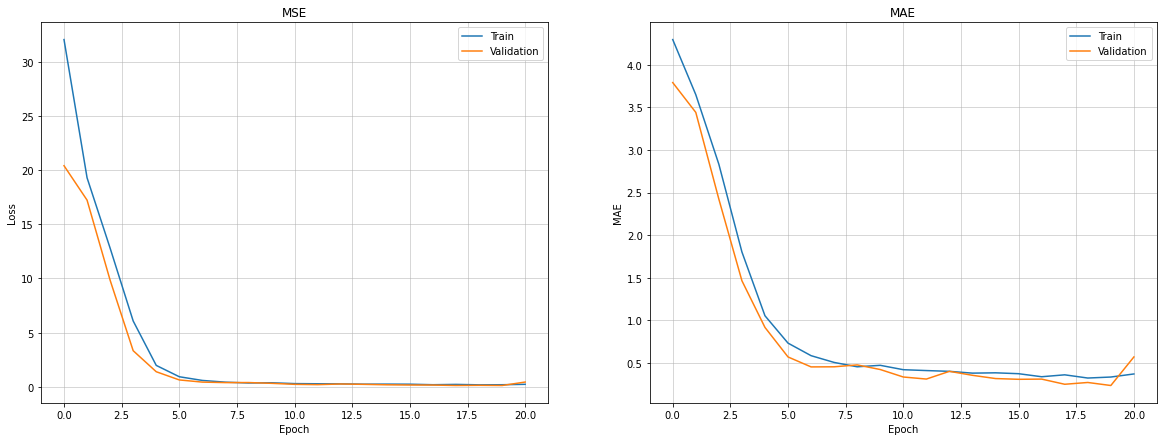

In [125]:
plot_history(history);

In [126]:
# 3 - Evaluation
# ====================================
res = model.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} Celsius degrees")

105/105 [==============================] - 4s 34ms/step - loss: 0.5931 - mae: 0.4488
The LSTM MAE on the test set is equal to 0.45 Celsius degrees


### A Baseline Model to compare our LSTM with

In [127]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    # $CHALLENGIFY_BEGIN
    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,1,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

In [128]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)} Celsius degrees")

105/105 [==============================] - 0s 1ms/step - loss: 0.3591 - mae: 0.2038
- The Baseline MAE on the test set is equal to 0.2 Celsius degrees


In [129]:
baseline_score[1]/res[1]

0.4540846993093036

In [130]:
print(f"- The LSTM MAE on the test set is equal to {round(res[1],2)} Celsius degrees")
print(f"🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : {abs(round((1 - (baseline_score[1]/res[1]))*100,2))} % 🔥")

- The LSTM MAE on the test set is equal to 0.45 Celsius degrees
🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : 54.59 % 🔥
